https://towardsdatascience.com/predict-the-number-of-likes-on-instagram-a7ec5c020203

# Imports

In [228]:
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 

from lib.utils import clean_sentence, clean_text
from lib.preprocess import calc_duration, transform_to_year, aggregate_transactions

In [351]:
import pandas as pd
import json
import numpy as np
import re
import pickle
from datetime import datetime
import tqdm

from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# import nltk
# import deeppavlov
import gensim
import gc
# from pymystem3 import Mystem
from gensim.models.wrappers import FastText

import matplotlib.pyplot as plt


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Loading

In [230]:
DATA_PATH = '../data_like/'

In [231]:
train = pd.read_csv(DATA_PATH+'customer_train.csv')
test = pd.read_csv(DATA_PATH+'customer_test.csv')

stories = pd.read_csv(DATA_PATH+'stories_description.csv')

train_y = pd.read_csv(DATA_PATH+'stories_reaction_train.csv')
test_y = pd.read_csv(DATA_PATH+'stories_reaction_test.csv')

transaction = pd.read_csv(DATA_PATH+'transactions.csv')

# Extracting text features from jsons

### !!!!Тема сториза!!!!1

In [234]:
REG_TEXT = "text\":\"(.*?)\","
REG_NAME = "name\":\"(.*?)\","
NUM_SWIPES = "description\":\"[0-9]{1,2}"

r = re.findall(REG_NAME, stories['story_json'][10])

In [235]:
decoded_stories = dict()
for i in stories.index:
    cur_story = stories['story_json'][i]
    story_info = dict()
    name = re.findall(REG_NAME, cur_story)
    story_info['name'] = "" if len(name) == 0 else clean_sentence(name[0])
    story_info['text'], story_info['n_words'] = clean_text(re.findall(REG_TEXT, cur_story))
    story_info['swipes'] = len(re.findall(NUM_SWIPES, cur_story))
    decoded_stories[stories['story_id'][i]] = story_info

In [237]:
with open("stories", "wb") as fp:
    pickle.dump(decoded_stories, fp)

In [10]:
# with open("stories", "rb") as fp:
#     b = pickle.load(fp)

# Data Analysis 

## 1) Likes, Dislikes and other stuff

In [238]:
len(list(set(train_y.customer_id).intersection(set(test_y.customer_id))))

14260

In [239]:
len(list(set(train_y.story_id).intersection(set(test_y.story_id))))

670

#### Some customers from train are also in test as well as stories

In [240]:
inter = list(set(train_y.customer_id).intersection(set(test_y.customer_id)))
num = 4

In [241]:
train_y[train_y.customer_id==inter[num]]

,customer_id,story_id,event_dttm,event
444336,917520,129,2018-05-31 05:05:34,view
444337,917520,129,2018-06-01 13:14:11,view
444338,917520,133,2018-05-28 11:58:47,skip
444339,917520,136,2018-05-28 11:58:47,view
444340,917520,138,2018-06-20 15:50:13,skip
...,...,...,...,...
444595,917520,1359,2018-07-22 11:52:37,view
444596,917520,1372,2018-07-27 07:21:05,view
444597,917520,1385,2018-07-27 07:21:05,skip
444598,917520,1407,2018-07-30 16:31:53,view


#### Customers can watch the same stories few times, can be a good feature

In [242]:
train_y.event.value_counts() / len(train_y)

view       0.512135
skip       0.354159
like       0.119810
dislike    0.013896
Name: event, dtype: float64

top_liked : top_disliked  ==  31 <br>
top_viewed : top_disliked  ==  22 <br>
top_skiped : top_disliked  ==  20 <br>
top_viewed : top_liked  == 29 <br>
top_skiped : top_liked == 24 <br>
top_viewed : top_skiped == 27 <br>

### ???? disliked are much more similar to liked, may be it is a misclick of user ?????

## 2) Users info

#### Let's watch by eyes to data

In [243]:
# categorial_feat = ['product_0', 'product_1', 'product_2', 'product_3', 
#                    'product_4', 'product_5', 'product_6', 'gender_cd',
#                    'marital_status_cd', 'children_cnt', 'job_position_cd', 'job_title']
# for col in categorial_feat:
#     print('FEATURE:', col)
#     print(train[col].value_counts())
#     print('Nans:', len(train) - np.sum(train[col].value_counts()))
#     print('_________')

#### Let's see data of registration

In [244]:
years = []
for i in range(len(train)):
    if isinstance(train.first_session_dttm[i], str):
        years.append(datetime.strptime(train.first_session_dttm[i], '%Y-%m-%d %H:%M:%S').year)
    else:
        years.append('NaN')
np.unique(years)

TypeError: isinstance() arg 2 must be a type or tuple of types

#### Let's see age

In [245]:
train.age = train.age.fillna(0)
np.unique(train.age)

array([ 0., 15., 20., 25., 30., 35., 40., 45., 50., 55., 60., 65., 70.,
       75., 80., 85.])

### can use it as a categorial feature

## 3) Transactions

In [ ]:
# description.loc[transaction.columns].iloc[3: ]

#### There are a lot of popular shops, maybe like x5 

In [249]:
len(transaction.merchant_mcc.value_counts())

409

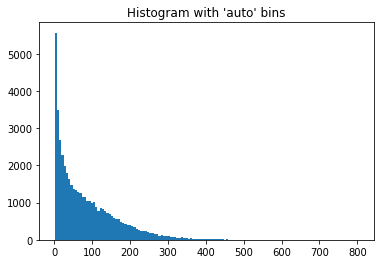

514522     804
588639     788
333041     768
588106     700
673392     690
          ... 
542958       1
462666       1
743422       1
1010076      1
195566       1
Name: customer_id, Length: 46948, dtype: int64

In [250]:
_ = plt.hist(transaction.customer_id.value_counts(), bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()
transaction.customer_id.value_counts()

#### Ideas: <br> 1. average amount of money for transaction for each user, two features: average over all transactions and of >0 rubles transactions<br> 2. average number of transaction per month <br> 3. Maybe if user visits top popular shops 

# -----------------------------

# Preprocessing

## 1) Customer_train/test

Порезаьть те вещи, которые я указал выше - done<br>
Посчитать число лет от текущего момента - done <br>
Переделать дату - done

In [251]:
train = pd.read_csv(DATA_PATH+'customer_train.csv')
test = pd.read_csv(DATA_PATH+'customer_test.csv')
print(train.shape)
print(test.shape)

(50000, 15)
(54245, 15)


#### Cutting very rare stuff

In [252]:
nan = 'NAN'
train = train.fillna(nan)

In [258]:
# Delete rare jobs because it may be useless during one-hot encoding
train.job_title = [job.lower() if isinstance(job, type('aaa')) else job for job in train.job_title]
common_jobs = set(train['job_title'].value_counts().keys()[train['job_title'].value_counts() > 50])
train.job_title = [job if job in common_jobs else nan for job in train.job_title]

In [259]:
common_n_status = set(train['marital_status_cd'].value_counts().keys()[train['marital_status_cd'].value_counts() > 2])
train.marital_status_cd = [ch if ch in common_n_status else nan for ch in train.marital_status_cd]

#### Calculating amount of time since regestration till now

In [265]:
datetime.strptime(train.first_session_dttm[1], '%Y-%m-%d %H:%M:%S').year

TypeError: strptime() argument 1 must be str, not int

In [261]:
(datetime.today() - datetime.strptime(train.first_session_dttm[1], '%Y-%m-%d %H:%M:%S')).days / 365

2.5232876712328767

In [262]:
calc_duration(train)

#### Transform data of reg to Year of registration

In [263]:
transform_to_year(train)

In [264]:
train.first_session_dttm.value_counts()

2017    18536
2018    11849
2016     8762
2015     4673
2014     2323
2013     2146
2012     1696
2019       12
NAN         3
Name: first_session_dttm, dtype: int64

#### One-Hot-Encode

In [266]:
features_to_encode = ['product_0', 'product_1', 'product_2', 'product_3',
                      'product_4', 'product_5', 'product_6', 'gender_cd', 'age',
                      'marital_status_cd', 'children_cnt', 'first_session_dttm',
                      'job_position_cd', 'job_title']
train_transformed = pd.get_dummies(train, columns=['product_0', 'product_1', 'product_2', 'product_3',
       'product_4', 'product_5', 'product_6', 'gender_cd', 'age',
       'marital_status_cd', 'children_cnt', 'first_session_dttm',
       'job_position_cd', 'job_title'])

In [267]:
train_transformed.index = train_transformed['customer_id']
train_transformed = train_transformed.drop(columns='customer_id')

/Users/farshov/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


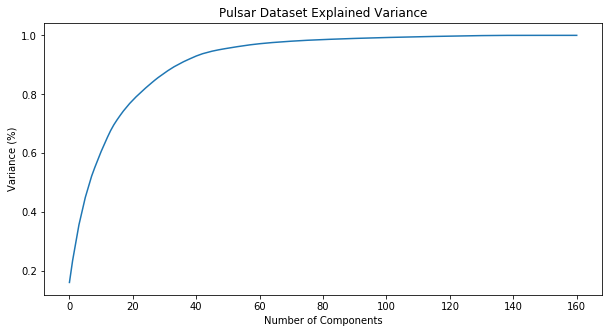

In [54]:
#Fitting the PCA algorithm with our Data
scaler = MinMaxScaler(feature_range=[0, 1])
data_rescaled = scaler.fit_transform(train_transformed, )
pca = PCA().fit(data_rescaled)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.show()

In [269]:
train_transformed.columns

Index(['duration', 'product_0_CLS', 'product_0_NAN', 'product_0_UTL',
       'product_1_CLS', 'product_1_NAN', 'product_1_OPN', 'product_1_UTL',
       'product_2_CLS', 'product_2_NAN',
       ...
       'job_title_старший специалист', 'job_title_студент',
       'job_title_торговый представитель', 'job_title_управляющий',
       'job_title_учитель', 'job_title_учредитель', 'job_title_экономист',
       'job_title_эксперт', 'job_title_электромонтер', 'job_title_юрист'],
      dtype='object', length=160)

## 2) Transactions

Средняя сумма транзакций с нулями и без - done <br>
Кол-во транзакций с нулями и без - done <br>

In [270]:
transactions = aggregate_transactions(DATA_PATH+'transactions.csv')

In [273]:
transactions.head()

,av,av_n_z,num_tr,num_tr_n_z
15,22210.000000,23627.659574,100.0,2221000.0
73,3768.852459,5063.876652,305.0,1149500.0
91,3588.983051,4505.319149,118.0,423500.0
144,1000.000000,1250.000000,5.0,5000.0
150,0.000000,0.000000,4.0,1.0


## 3) Stories

In [16]:
stories = pd.read_csv(DATA_PATH+'stories_description.csv')

In [17]:
model = FastText.load_fasttext_format('../PretrainedEmbeddings/ft_native_300_ru_wiki_lenta_remstopwords.bin')

In [71]:
REG_TEXT = "text\":\"(.*?)\","
REG_NAME = "name\":\"(.*?)\","
NUM_SWIPES = "description\":\"[0-9]{1,2}"

In [114]:
decoded_stories = dict()
for i in stories.index:
    cur_story = stories['story_json'][i]
    story_info = dict()
    name = re.findall(REG_NAME, cur_story)
    name = "" if len(name) == 0 else clean_sentence(name[0]).split()
    name_n = []
    for w in name:
        if len(w) > 1:
            name_n.append(w)
    story_info['name'] = name_n
    story_info['text'], story_info['n_words'] = clean_text(re.findall(REG_TEXT, cur_story))
    story_info['swipes'] = len(re.findall(NUM_SWIPES, cur_story))
    decoded_stories[stories['story_id'][i]] = story_info

In [126]:
(model.wv['привет'] - np.mean(model.wv['привет'])) / np.std(model.wv['привет'])

array([-1.65821195e+00,  1.31126368e+00,  1.11925006e-01, -6.35337055e-01,
       -7.50740767e-01,  3.37734342e-01, -2.09613276e+00,  1.36840236e+00,
        7.63694286e-01, -4.88340646e-01, -5.61835766e-01, -3.97025704e-01,
        2.76810765e-01,  3.71007800e-01,  1.30063474e+00,  1.02928901e+00,
        1.09104657e+00, -7.88901627e-01,  2.04760599e+00, -3.70487213e-01,
       -2.02876270e-01,  1.23779930e-01, -6.12025082e-01,  9.36453700e-01,
        4.83175188e-01, -1.00241053e+00,  9.64126706e-01,  7.38306418e-02,
       -9.00948703e-01, -7.50917912e-01, -8.50287676e-01, -7.01440990e-01,
       -1.43484962e+00, -1.30830562e+00,  8.12201142e-01, -1.16317105e+00,
       -1.16751134e+00, -2.08505917e+00, -5.40413022e-01,  1.85806251e+00,
       -1.11552924e-01,  6.00020826e-01,  2.48514060e-02,  5.96771836e-01,
       -5.58572292e-01, -7.21455216e-01, -1.71591723e+00, -2.07547927e+00,
        6.71559036e-01,  9.93494749e-01, -1.01905072e+00,  8.30330968e-01,
        5.15706956e-01, -

In [131]:
embedded_stories = dict()
for key in decoded_stories.keys():
    cur_story = decoded_stories[key]
    cur_emb = np.zeros(300)
    for i in range(len(cur_story['text'])):
        try:
            cur_emb += np.average(model.wv[cur_story['text'][i]], axis=0)
        except KeyError:
            continue
    try:
        cur_emb += np.average(model.wv[cur_story['name']], axis=0)
    except:
        pass
    cur_emb = (cur_emb - np.mean(cur_emb)) / (np.std(cur_emb) + 1e-8)
    embedded_stories[key] = {'emb': cur_emb,
                             'n_words': cur_story['n_words'],
                             'swipes' : cur_story['swipes']
                            }

## 4) Whatching the same stories twice

Смотрел ужк или нет <br>
Сколько раз смотрел на текущий момент

In [205]:
train_y = pd.read_csv(DATA_PATH+'stories_reaction_train.csv')
test_y = pd.read_csv(DATA_PATH+'stories_reaction_test.csv')

In [206]:
train_y.head()

,customer_id,story_id,event_dttm,event
0,15,138,2018-07-24 15:33:22,view
1,15,202,2018-06-04 08:08:08,skip
2,15,222,2018-06-17 13:44:45,skip
3,15,379,2018-05-23 05:41:43,skip
4,15,544,2018-07-25 02:16:29,view


In [208]:
y = pd.concat([train_y.drop(columns='event'), test_y.drop(columns='answer_id')])

In [209]:
y.index = y.customer_id
y = y.drop(columns='customer_id')
y.head()

,story_id,event_dttm
customer_id,,
15,138,2018-07-24 15:33:22
15,202,2018-06-04 08:08:08
15,222,2018-06-17 13:44:45
15,379,2018-05-23 05:41:43
15,544,2018-07-25 02:16:29


In [210]:
np.array(y.loc[15][y.loc[15]['story_id'] == 888]['event_dttm'])

array(['2018-07-28 10:53:23', '2018-07-29 01:49:35'], dtype=object)

In [211]:
sorted([datetime.strptime('2018-07-23 15:33:22', '%Y-%m-%d %H:%M:%S'), 
        datetime.strptime('2018-07-24 15:33:22', '%Y-%m-%d %H:%M:%S')])

[datetime.datetime(2018, 7, 23, 15, 33, 22),
 datetime.datetime(2018, 7, 24, 15, 33, 22)]

In [218]:
idxs = np.unique(y.index)
customer_views = dict()
for id_c in idxs:
    cur_y = y.loc[id_c]
    cur_customer_views = dict()
    for story in np.unique(cur_y['story_id']):
        cur_story = dict()
        dates = cur_y[cur_y['story_id'] == story]
        # print(type(dates), story)
        if type(dates) != type('aaa'):
            dates = np.array(dates['event_dttm'])
        else:
            dates = [dates]
        dates = sorted([datetime.strptime(time, '%Y-%m-%d %H:%M:%S') for time in dates])
        for j in range(len(dates)):
            cur_story[dates[j]] = j
        cur_customer_views[story] = cur_story
    customer_views[id_c] = cur_customer_views

In [298]:
# customer_views

## 5) Aggregating all previous into one dataset

In [225]:
train_y.head()

,customer_id,story_id,event_dttm,event
0,15,138,2018-07-24 15:33:22,view
1,15,202,2018-06-04 08:08:08,skip
2,15,222,2018-06-17 13:44:45,skip
3,15,379,2018-05-23 05:41:43,skip
4,15,544,2018-07-25 02:16:29,view


In [279]:
train_y.iloc[0]['customer_id']

15

In [280]:
train_transformed.head()

,duration,product_0_CLS,product_0_NAN,product_0_UTL,product_1_CLS,product_1_NAN,product_1_OPN,product_1_UTL,product_2_CLS,product_2_NAN,...,job_title_старший специалист,job_title_студент,job_title_торговый представитель,job_title_управляющий,job_title_учитель,job_title_учредитель,job_title_экономист,job_title_эксперт,job_title_электромонтер,job_title_юрист
customer_id,,,,,,,,,,,,,,,,,,,,,
894436,1.550685,0,1,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
524526,2.523288,0,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
498134,1.572603,0,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
278941,3.624658,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
877312,1.586301,0,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [282]:
transactions.head()

,av,av_n_z,num_tr,num_tr_n_z
15,22210.000000,23627.659574,100.0,2221000.0
73,3768.852459,5063.876652,305.0,1149500.0
91,3588.983051,4505.319149,118.0,423500.0
144,1000.000000,1250.000000,5.0,5000.0
150,0.000000,0.000000,4.0,1.0


In [296]:
[2, 3] + [embedded_stories[127]['swipes']]

[2, 3, 4]

In [301]:
customer_views[15][888]

{datetime.datetime(2018, 7, 28, 10, 53, 23): 0,
 datetime.datetime(2018, 7, 29, 1, 49, 35): 1}

In [304]:
datetime.strptime(train_y.loc[0]['event_dttm'], '%Y-%m-%d %H:%M:%S')

datetime.datetime(2018, 7, 24, 15, 33, 22)

In [310]:
len(set(transactions.index).intersection(set(train_y.customer_id)))

36446

In [312]:
len(np.unique(train_y.customer_id))

41001

#### Not all cusomers from trani_y are in transactions, so swap their info to average

In [318]:
av_transaction = list(np.mean(transactions, axis=0))

In [319]:
av_transaction

[1212.4871354047252, 1792.7243260481805, 84.15938911135724, 82035.79185481809]

#### Not all stories from train_y are in stories, so swap their info to average. Maybe we should just drop them from dataset??

In [336]:
embs = np.zeros(300)
words = 0
swipes = 0
num_stories = len(embedded_stories.keys())
for key in embedded_stories.keys():
    embs += embedded_stories[key]['emb']
    words += embedded_stories[key]['n_words']
    swipes += embedded_stories[key]['swipes']

In [339]:
av_story = {'emb': embs / num_stories,
            'n_words': words // num_stories,
            'swipes': swipes // num_stories
           }

#### The same with users. Solution: just drop those users

In [357]:
final_df = []
final_labels = []
for i in tqdm.tqdm(range(len(train_y))):
    row = []
    cur_view = train_y.iloc[i]
    
    cus_id = cur_view['customer_id']
    try:
        row += list(train_transformed.loc[cus_id])
    except KeyError:
        continue
    try:
        row += list(transactions.loc[cus_id])
    except KeyError:
        row += av_transaction
    
    story_id = cur_view['story_id']
    try:
        story = embedded_stories[story_id]
    except KeyError:
        story = av_story
    row += [story['n_words']]
    row += [story['swipes']]
    row += list(story['emb'])
    
    view_date = datetime.strptime(cur_view['event_dttm'], '%Y-%m-%d %H:%M:%S')
    num_prev = customer_views[cus_id][story_id][view_date]
    if num_prev:
        row += [num_prev, 1]
    else:
        row += [num_prev, 0]
    final_df.append(row)
    final_labels.append(cur_view.event)



  0%|          | 0/473141 [00:00<?, ?it/s]

  0%|          | 161/473141 [00:00<04:54, 1604.98it/s]

  0%|          | 317/473141 [00:00<04:57, 1589.32it/s]

  0%|          | 484/473141 [00:00<04:53, 1611.03it/s]

  0%|          | 641/473141 [00:00<04:57, 1590.53it/s]

  0%|          | 798/473141 [00:00<04:58, 1582.93it/s]

  0%|          | 959/473141 [00:00<04:56, 1590.31it/s]

  0%|          | 1120/473141 [00:00<04:56, 1594.66it/s]

  0%|          | 1282/473141 [00:00<04:54, 1601.61it/s]

  0%|          | 1434/473141 [00:00<04:59, 1573.70it/s]

  0%|          | 1648/473141 [00:01<04:36, 1708.09it/s]

  0%|          | 1818/473141 [00:01<04:43, 1662.38it/s]

  0%|          | 1984/473141 [00:01<04:44, 1654.65it/s]

  0%|          | 2214/473141 [00:01<04:20, 1804.94it/s]

  1%|          | 2399/473141 [00:01<04:29, 1743.83it/s]

  1%|          | 2577/473141 [00:01<04:39, 1685.81it/s]

  1%|          | 2749/473141 [00:01<04:44, 1652.37it/s]

  1%|          | 2917/473141 [00:01<04:49, 1626.

  5%|▍         | 21818/473141 [00:13<04:17, 1751.23it/s]

  5%|▍         | 22001/473141 [00:13<04:24, 1705.87it/s]

  5%|▍         | 22178/473141 [00:13<04:28, 1680.01it/s]

  5%|▍         | 22351/473141 [00:13<04:33, 1649.62it/s]

  5%|▍         | 22597/473141 [00:13<04:06, 1829.42it/s]

  5%|▍         | 22789/473141 [00:13<04:19, 1738.48it/s]

  5%|▍         | 22970/473141 [00:14<04:27, 1684.66it/s]

  5%|▍         | 23144/473141 [00:14<04:32, 1648.93it/s]

  5%|▍         | 23313/473141 [00:14<04:40, 1605.11it/s]

  5%|▍         | 23477/473141 [00:14<04:42, 1591.04it/s]

  5%|▍         | 23639/473141 [00:14<04:45, 1573.62it/s]

  5%|▌         | 23807/473141 [00:14<04:40, 1604.09it/s]

  5%|▌         | 23969/473141 [00:14<04:46, 1569.40it/s]

  5%|▌         | 24131/473141 [00:14<04:43, 1583.75it/s]

  5%|▌         | 24291/473141 [00:14<04:42, 1586.26it/s]

  5%|▌         | 24463/473141 [00:15<04:36, 1623.79it/s]

  5%|▌         | 24626/473141 [00:15<04:41, 1596.00it/s]

  5%|▌        

  9%|▉         | 42989/473141 [00:26<04:40, 1531.18it/s]

  9%|▉         | 43145/473141 [00:26<04:39, 1539.42it/s]

  9%|▉         | 43316/473141 [00:26<04:31, 1585.84it/s]

  9%|▉         | 43503/473141 [00:27<04:18, 1661.16it/s]

  9%|▉         | 43671/473141 [00:27<04:48, 1490.05it/s]

  9%|▉         | 43866/473141 [00:27<04:27, 1602.82it/s]

  9%|▉         | 44068/473141 [00:27<04:11, 1706.16it/s]

  9%|▉         | 44245/473141 [00:27<04:20, 1648.86it/s]

  9%|▉         | 44415/473141 [00:27<04:27, 1603.96it/s]

  9%|▉         | 44581/473141 [00:27<04:24, 1617.25it/s]

  9%|▉         | 44746/473141 [00:27<04:28, 1595.28it/s]

  9%|▉         | 44908/473141 [00:27<04:29, 1591.08it/s]

 10%|▉         | 45069/473141 [00:27<04:30, 1584.20it/s]

 10%|▉         | 45229/473141 [00:28<04:34, 1560.05it/s]

 10%|▉         | 45386/473141 [00:28<04:35, 1554.34it/s]

 10%|▉         | 45569/473141 [00:28<04:22, 1627.85it/s]

 10%|▉         | 45838/473141 [00:28<03:51, 1844.63it/s]

 10%|▉        

 14%|█▎        | 64631/473141 [00:40<04:23, 1549.68it/s]

 14%|█▎        | 64787/473141 [00:40<04:23, 1547.35it/s]

 14%|█▎        | 65011/473141 [00:40<03:59, 1705.03it/s]

 14%|█▍        | 65208/473141 [00:40<03:49, 1774.41it/s]

 14%|█▍        | 65390/473141 [00:40<04:00, 1697.29it/s]

 14%|█▍        | 65564/473141 [00:40<04:11, 1617.69it/s]

 14%|█▍        | 65730/473141 [00:40<04:13, 1604.61it/s]

 14%|█▍        | 65893/473141 [00:40<04:18, 1573.68it/s]

 14%|█▍        | 66053/473141 [00:41<04:20, 1562.00it/s]

 14%|█▍        | 66211/473141 [00:41<04:24, 1540.50it/s]

 14%|█▍        | 66367/473141 [00:41<04:24, 1537.54it/s]

 14%|█▍        | 66522/473141 [00:41<04:24, 1539.95it/s]

 14%|█▍        | 66758/473141 [00:41<03:56, 1717.30it/s]

 14%|█▍        | 66937/473141 [00:41<04:06, 1647.56it/s]

 14%|█▍        | 67108/473141 [00:41<04:06, 1647.29it/s]

 14%|█▍        | 67277/473141 [00:41<04:11, 1615.75it/s]

 14%|█▍        | 67633/473141 [00:41<03:30, 1930.59it/s]

 14%|█▍       

 18%|█▊        | 86357/473141 [00:53<04:01, 1599.25it/s]

 18%|█▊        | 86583/473141 [00:53<03:40, 1750.69it/s]

 18%|█▊        | 86771/473141 [00:53<03:36, 1786.28it/s]

 18%|█▊        | 86954/473141 [00:53<03:46, 1703.53it/s]

 18%|█▊        | 87128/473141 [00:54<03:53, 1652.92it/s]

 18%|█▊        | 87297/473141 [00:54<04:00, 1607.01it/s]

 18%|█▊        | 87460/473141 [00:54<04:02, 1587.67it/s]

 19%|█▊        | 87621/473141 [00:54<04:03, 1582.99it/s]

 19%|█▊        | 87781/473141 [00:54<04:05, 1568.36it/s]

 19%|█▊        | 87939/473141 [00:54<04:08, 1547.47it/s]

 19%|█▊        | 88095/473141 [00:54<04:08, 1549.43it/s]

 19%|█▊        | 88251/473141 [00:54<04:08, 1547.82it/s]

 19%|█▊        | 88413/473141 [00:54<04:05, 1566.71it/s]

 19%|█▊        | 88570/473141 [00:55<04:29, 1427.15it/s]

 19%|█▉        | 88718/473141 [00:55<04:26, 1441.54it/s]

 19%|█▉        | 88894/473141 [00:55<04:12, 1523.51it/s]

 19%|█▉        | 89070/473141 [00:55<04:02, 1584.24it/s]

 19%|█▉       

 23%|██▎       | 107406/473141 [01:06<03:47, 1604.99it/s]

 23%|██▎       | 107572/473141 [01:06<03:52, 1573.15it/s]

 23%|██▎       | 107749/473141 [01:07<03:44, 1625.45it/s]

 23%|██▎       | 107915/473141 [01:07<03:49, 1590.13it/s]

 23%|██▎       | 108077/473141 [01:07<03:52, 1568.11it/s]

 23%|██▎       | 108236/473141 [01:07<03:55, 1552.16it/s]

 23%|██▎       | 108393/473141 [01:07<03:58, 1529.16it/s]

 23%|██▎       | 108547/473141 [01:07<03:58, 1529.32it/s]

 23%|██▎       | 108716/473141 [01:07<03:51, 1571.49it/s]

 23%|██▎       | 108878/473141 [01:07<03:49, 1585.47it/s]

 23%|██▎       | 109042/473141 [01:07<03:47, 1598.98it/s]

 23%|██▎       | 109203/473141 [01:08<03:52, 1563.03it/s]

 23%|██▎       | 109360/473141 [01:08<03:54, 1550.36it/s]

 23%|██▎       | 109516/473141 [01:08<03:56, 1540.43it/s]

 23%|██▎       | 109671/473141 [01:08<03:56, 1537.83it/s]

 23%|██▎       | 109825/473141 [01:08<03:58, 1521.14it/s]

 23%|██▎       | 109994/473141 [01:08<03:51, 1565.56it/s

 27%|██▋       | 127763/473141 [01:19<03:50, 1501.27it/s]

 27%|██▋       | 127914/473141 [01:20<03:49, 1502.35it/s]

 27%|██▋       | 128065/473141 [01:20<03:50, 1497.42it/s]

 27%|██▋       | 128231/473141 [01:20<03:43, 1542.28it/s]

 27%|██▋       | 128386/473141 [01:20<03:45, 1526.79it/s]

 27%|██▋       | 128541/473141 [01:20<03:44, 1532.44it/s]

 27%|██▋       | 128695/473141 [01:20<03:46, 1518.18it/s]

 27%|██▋       | 128848/473141 [01:20<03:48, 1503.59it/s]

 27%|██▋       | 128999/473141 [01:20<03:49, 1502.49it/s]

 27%|██▋       | 129150/473141 [01:20<03:49, 1497.36it/s]

 27%|██▋       | 129309/473141 [01:20<03:45, 1522.96it/s]

 27%|██▋       | 129462/473141 [01:21<03:48, 1502.93it/s]

 27%|██▋       | 129633/473141 [01:21<03:40, 1558.14it/s]

 27%|██▋       | 129794/473141 [01:21<03:38, 1571.50it/s]

 27%|██▋       | 129952/473141 [01:21<03:41, 1550.13it/s]

 27%|██▋       | 130112/473141 [01:21<03:39, 1564.34it/s]

 28%|██▊       | 130269/473141 [01:21<03:43, 1532.87it/s

 31%|███▏      | 148222/473141 [01:33<03:24, 1591.37it/s]

 31%|███▏      | 148397/473141 [01:33<03:18, 1634.71it/s]

 31%|███▏      | 148569/473141 [01:33<03:15, 1658.21it/s]

 31%|███▏      | 148736/473141 [01:33<03:22, 1601.79it/s]

 31%|███▏      | 148897/473141 [01:33<03:23, 1590.24it/s]

 32%|███▏      | 149059/473141 [01:33<03:22, 1597.94it/s]

 32%|███▏      | 149220/473141 [01:33<03:25, 1575.36it/s]

 32%|███▏      | 149378/473141 [01:33<03:29, 1546.47it/s]

 32%|███▏      | 149537/473141 [01:33<03:27, 1558.06it/s]

 32%|███▏      | 149694/473141 [01:33<03:28, 1551.55it/s]

 32%|███▏      | 149850/473141 [01:34<03:29, 1541.83it/s]

 32%|███▏      | 150005/473141 [01:34<03:30, 1534.96it/s]

 32%|███▏      | 150159/473141 [01:34<03:45, 1430.91it/s]

 32%|███▏      | 150314/473141 [01:34<03:40, 1462.44it/s]

 32%|███▏      | 150471/473141 [01:34<03:36, 1491.07it/s]

 32%|███▏      | 150625/473141 [01:34<03:34, 1504.60it/s]

 32%|███▏      | 150777/473141 [01:34<03:35, 1497.87it/s

 36%|███▌      | 168938/473141 [01:46<03:15, 1555.18it/s]

 36%|███▌      | 169095/473141 [01:46<03:16, 1550.07it/s]

 36%|███▌      | 169333/473141 [01:46<02:55, 1730.57it/s]

 36%|███▌      | 169514/473141 [01:46<02:59, 1687.67it/s]

 36%|███▌      | 169688/473141 [01:46<03:03, 1651.47it/s]

 36%|███▌      | 169857/473141 [01:46<03:04, 1645.71it/s]

 36%|███▌      | 170025/473141 [01:46<03:06, 1626.49it/s]

 36%|███▌      | 170190/473141 [01:46<03:10, 1594.25it/s]

 36%|███▌      | 170400/473141 [01:47<02:56, 1717.76it/s]

 36%|███▌      | 170576/473141 [01:47<03:02, 1659.25it/s]

 36%|███▌      | 170745/473141 [01:47<03:05, 1631.61it/s]

 36%|███▌      | 170911/473141 [01:47<03:09, 1593.48it/s]

 36%|███▌      | 171073/473141 [01:47<03:15, 1548.45it/s]

 36%|███▌      | 171230/473141 [01:47<03:16, 1533.52it/s]

 36%|███▌      | 171390/473141 [01:47<03:14, 1550.36it/s]

 36%|███▋      | 171546/473141 [01:47<03:16, 1532.29it/s]

 36%|███▋      | 171700/473141 [01:47<03:18, 1515.77it/s

 40%|████      | 189609/473141 [01:59<02:49, 1671.87it/s]

 40%|████      | 189783/473141 [01:59<02:52, 1639.63it/s]

 40%|████      | 189952/473141 [01:59<02:55, 1609.74it/s]

 40%|████      | 190117/473141 [01:59<02:58, 1583.46it/s]

 40%|████      | 190278/473141 [01:59<03:01, 1556.36it/s]

 40%|████      | 190438/473141 [01:59<03:00, 1567.93it/s]

 40%|████      | 190599/473141 [01:59<02:59, 1577.43it/s]

 40%|████      | 190759/473141 [02:00<02:58, 1583.56it/s]

 40%|████      | 190918/473141 [02:00<03:03, 1540.49it/s]

 40%|████      | 191073/473141 [02:00<03:02, 1542.68it/s]

 40%|████      | 191233/473141 [02:00<03:00, 1558.24it/s]

 40%|████      | 191395/473141 [02:00<02:59, 1573.85it/s]

 40%|████      | 191553/473141 [02:00<03:00, 1559.60it/s]

 41%|████      | 191710/473141 [02:00<03:02, 1542.59it/s]

 41%|████      | 191865/473141 [02:00<03:02, 1541.13it/s]

 41%|████      | 192020/473141 [02:00<03:02, 1543.78it/s]

 41%|████      | 192178/473141 [02:00<03:00, 1553.31it/s

 45%|████▍     | 211025/473141 [02:12<02:45, 1584.53it/s]

 45%|████▍     | 211185/473141 [02:12<02:46, 1576.55it/s]

 45%|████▍     | 211344/473141 [02:12<02:46, 1572.04it/s]

 45%|████▍     | 211502/473141 [02:12<02:48, 1555.30it/s]

 45%|████▍     | 211658/473141 [02:12<02:48, 1553.71it/s]

 45%|████▍     | 211814/473141 [02:13<02:50, 1535.15it/s]

 45%|████▍     | 211991/473141 [02:13<02:43, 1598.56it/s]

 45%|████▍     | 212152/473141 [02:13<02:43, 1592.62it/s]

 45%|████▍     | 212312/473141 [02:13<02:45, 1572.80it/s]

 45%|████▍     | 212470/473141 [02:13<03:00, 1443.82it/s]

 45%|████▍     | 212623/473141 [02:13<02:57, 1467.40it/s]

 45%|████▍     | 212783/473141 [02:13<02:53, 1504.68it/s]

 45%|████▌     | 212948/473141 [02:13<02:48, 1545.01it/s]

 45%|████▌     | 213129/473141 [02:13<02:40, 1615.42it/s]

 45%|████▌     | 213293/473141 [02:14<02:44, 1578.51it/s]

 45%|████▌     | 213457/473141 [02:14<02:43, 1593.01it/s]

 45%|████▌     | 213618/473141 [02:14<02:44, 1579.56it/s

 49%|████▉     | 231825/473141 [02:25<02:34, 1566.30it/s]

 49%|████▉     | 231983/473141 [02:25<02:35, 1549.91it/s]

 49%|████▉     | 232139/473141 [02:25<02:36, 1544.38it/s]

 49%|████▉     | 232307/473141 [02:25<02:32, 1581.83it/s]

 49%|████▉     | 232531/473141 [02:26<02:19, 1723.77it/s]

 49%|████▉     | 232708/473141 [02:26<02:24, 1658.88it/s]

 49%|████▉     | 232878/473141 [02:26<02:25, 1652.68it/s]

 49%|████▉     | 233046/473141 [02:26<02:28, 1621.93it/s]

 49%|████▉     | 233210/473141 [02:26<02:28, 1617.00it/s]

 49%|████▉     | 233373/473141 [02:26<02:28, 1613.74it/s]

 49%|████▉     | 233536/473141 [02:26<02:28, 1612.87it/s]

 49%|████▉     | 233726/473141 [02:26<02:21, 1689.05it/s]

 49%|████▉     | 233897/473141 [02:26<02:26, 1635.07it/s]

 49%|████▉     | 234062/473141 [02:27<02:26, 1628.23it/s]

 50%|████▉     | 234267/473141 [02:27<02:17, 1733.48it/s]

 50%|████▉     | 234443/473141 [02:27<02:22, 1672.06it/s]

 50%|████▉     | 234613/473141 [02:27<02:26, 1633.42it/s

 53%|█████▎    | 252795/473141 [02:38<02:20, 1564.31it/s]

 53%|█████▎    | 253028/473141 [02:38<02:06, 1734.25it/s]

 54%|█████▎    | 253208/473141 [02:39<02:12, 1665.35it/s]

 54%|█████▎    | 253380/473141 [02:39<02:15, 1618.22it/s]

 54%|█████▎    | 253546/473141 [02:39<02:19, 1571.32it/s]

 54%|█████▎    | 253707/473141 [02:39<02:21, 1553.56it/s]

 54%|█████▎    | 253865/473141 [02:39<02:21, 1553.63it/s]

 54%|█████▎    | 254022/473141 [02:39<02:22, 1539.09it/s]

 54%|█████▎    | 254177/473141 [02:39<02:23, 1530.80it/s]

 54%|█████▍    | 254332/473141 [02:39<02:22, 1535.29it/s]

 54%|█████▍    | 254487/473141 [02:39<02:23, 1526.03it/s]

 54%|█████▍    | 254648/473141 [02:40<02:21, 1549.12it/s]

 54%|█████▍    | 254804/473141 [02:40<02:22, 1535.43it/s]

 54%|█████▍    | 254958/473141 [02:40<02:22, 1532.08it/s]

 54%|█████▍    | 255112/473141 [02:40<02:22, 1531.71it/s]

 54%|█████▍    | 255273/473141 [02:40<02:20, 1552.88it/s]

 54%|█████▍    | 255432/473141 [02:40<02:19, 1561.13it/s

 58%|█████▊    | 274103/473141 [02:52<02:06, 1569.77it/s]

 58%|█████▊    | 274348/473141 [02:52<01:53, 1758.53it/s]

 58%|█████▊    | 274532/473141 [02:52<01:58, 1679.34it/s]

 58%|█████▊    | 274707/473141 [02:52<02:01, 1634.16it/s]

 58%|█████▊    | 274875/473141 [02:52<02:03, 1603.69it/s]

 58%|█████▊    | 275039/473141 [02:52<02:04, 1588.26it/s]

 58%|█████▊    | 275201/473141 [02:52<02:15, 1455.56it/s]

 58%|█████▊    | 275355/473141 [02:52<02:13, 1479.89it/s]

 58%|█████▊    | 275509/473141 [02:52<02:12, 1494.33it/s]

 58%|█████▊    | 275688/473141 [02:53<02:05, 1571.16it/s]

 58%|█████▊    | 275848/473141 [02:53<02:06, 1564.05it/s]

 58%|█████▊    | 276007/473141 [02:53<02:07, 1548.48it/s]

 58%|█████▊    | 276164/473141 [02:53<02:07, 1540.44it/s]

 58%|█████▊    | 276319/473141 [02:53<02:08, 1537.18it/s]

 58%|█████▊    | 276482/473141 [02:53<02:05, 1563.33it/s]

 58%|█████▊    | 276644/473141 [02:53<02:04, 1579.06it/s]

 59%|█████▊    | 276807/473141 [02:53<02:03, 1592.03it/s

 62%|██████▏   | 294955/473141 [03:05<01:57, 1518.18it/s]

 62%|██████▏   | 295115/473141 [03:05<01:55, 1541.68it/s]

 62%|██████▏   | 295278/473141 [03:05<01:53, 1564.37it/s]

 62%|██████▏   | 295456/473141 [03:05<01:49, 1620.13it/s]

 62%|██████▏   | 295619/473141 [03:05<01:50, 1610.81it/s]

 63%|██████▎   | 295781/473141 [03:05<01:52, 1574.77it/s]

 63%|██████▎   | 295939/473141 [03:05<01:53, 1565.70it/s]

 63%|██████▎   | 296096/473141 [03:05<01:53, 1556.41it/s]

 63%|██████▎   | 296262/473141 [03:06<01:51, 1586.09it/s]

 63%|██████▎   | 296421/473141 [03:06<01:51, 1578.93it/s]

 63%|██████▎   | 296580/473141 [03:06<01:53, 1554.95it/s]

 63%|██████▎   | 296736/473141 [03:06<01:54, 1542.38it/s]

 63%|██████▎   | 296891/473141 [03:06<01:54, 1536.35it/s]

 63%|██████▎   | 297058/473141 [03:06<01:52, 1572.06it/s]

 63%|██████▎   | 297216/473141 [03:06<01:52, 1559.39it/s]

 63%|██████▎   | 297382/473141 [03:06<01:50, 1586.26it/s]

 63%|██████▎   | 297541/473141 [03:06<01:52, 1566.97it/s

 67%|██████▋   | 316267/473141 [03:18<01:37, 1616.59it/s]

 67%|██████▋   | 316432/473141 [03:18<01:38, 1591.21it/s]

 67%|██████▋   | 316600/473141 [03:18<01:36, 1614.01it/s]

 67%|██████▋   | 316763/473141 [03:18<01:37, 1603.59it/s]

 67%|██████▋   | 316925/473141 [03:18<01:40, 1556.90it/s]

 67%|██████▋   | 317082/473141 [03:18<01:41, 1544.52it/s]

 67%|██████▋   | 317239/473141 [03:19<01:40, 1551.06it/s]

 67%|██████▋   | 317395/473141 [03:19<01:40, 1553.39it/s]

 67%|██████▋   | 317551/473141 [03:19<01:40, 1553.18it/s]

 67%|██████▋   | 317724/473141 [03:19<01:37, 1600.47it/s]

 67%|██████▋   | 317885/473141 [03:19<01:37, 1589.06it/s]

 67%|██████▋   | 318045/473141 [03:19<01:38, 1578.41it/s]

 67%|██████▋   | 318204/473141 [03:19<01:38, 1572.70it/s]

 67%|██████▋   | 318362/473141 [03:19<01:39, 1559.82it/s]

 67%|██████▋   | 318520/473141 [03:19<01:38, 1563.22it/s]

 67%|██████▋   | 318678/473141 [03:19<01:38, 1565.98it/s]

 67%|██████▋   | 318845/473141 [03:20<01:36, 1594.34it/s

 71%|███████   | 337066/473141 [03:31<01:29, 1522.48it/s]

 71%|███████▏  | 337219/473141 [03:31<01:29, 1524.61it/s]

 71%|███████▏  | 337372/473141 [03:31<01:36, 1407.86it/s]

 71%|███████▏  | 337537/473141 [03:31<01:32, 1471.54it/s]

 71%|███████▏  | 337706/473141 [03:31<01:28, 1530.35it/s]

 71%|███████▏  | 337862/473141 [03:32<01:28, 1525.37it/s]

 71%|███████▏  | 338018/473141 [03:32<01:28, 1533.79it/s]

 71%|███████▏  | 338173/473141 [03:32<01:28, 1523.81it/s]

 72%|███████▏  | 338328/473141 [03:32<01:28, 1529.72it/s]

 72%|███████▏  | 338489/473141 [03:32<01:26, 1550.09it/s]

 72%|███████▏  | 338645/473141 [03:32<01:29, 1501.73it/s]

 72%|███████▏  | 338810/473141 [03:32<01:27, 1542.05it/s]

 72%|███████▏  | 338971/473141 [03:32<01:25, 1561.33it/s]

 72%|███████▏  | 339130/473141 [03:32<01:25, 1569.14it/s]

 72%|███████▏  | 339371/473141 [03:33<01:16, 1750.70it/s]

 72%|███████▏  | 339554/473141 [03:33<01:19, 1678.92it/s]

 72%|███████▏  | 339728/473141 [03:33<01:22, 1619.24it/s

 76%|███████▌  | 358227/473141 [03:44<01:12, 1581.33it/s]

 76%|███████▌  | 358386/473141 [03:44<01:12, 1579.82it/s]

 76%|███████▌  | 358580/473141 [03:44<01:08, 1672.84it/s]

 76%|███████▌  | 358758/473141 [03:45<01:07, 1701.23it/s]

 76%|███████▌  | 358989/473141 [03:45<01:01, 1847.05it/s]

 76%|███████▌  | 359179/473141 [03:45<01:05, 1727.00it/s]

 76%|███████▌  | 359357/473141 [03:45<01:06, 1722.29it/s]

 76%|███████▌  | 359533/473141 [03:45<01:06, 1702.59it/s]

 76%|███████▌  | 359706/473141 [03:45<01:08, 1644.04it/s]

 76%|███████▌  | 359910/473141 [03:45<01:04, 1744.39it/s]

 76%|███████▌  | 360088/473141 [03:45<01:08, 1661.98it/s]

 76%|███████▌  | 360258/473141 [03:45<01:08, 1637.30it/s]

 76%|███████▌  | 360448/473141 [03:46<01:06, 1706.02it/s]

 76%|███████▋  | 360788/473141 [03:46<00:56, 2005.48it/s]

 76%|███████▋  | 361011/473141 [03:46<00:56, 1983.72it/s]

 76%|███████▋  | 361226/473141 [03:46<01:01, 1805.19it/s]

 76%|███████▋  | 361421/473141 [03:46<01:04, 1737.37it/s

 80%|████████  | 379582/473141 [03:57<00:58, 1590.99it/s]

 80%|████████  | 379742/473141 [03:58<00:59, 1570.42it/s]

 80%|████████  | 379903/473141 [03:58<00:58, 1580.32it/s]

 80%|████████  | 380062/473141 [03:58<00:59, 1571.90it/s]

 80%|████████  | 380220/473141 [03:58<00:59, 1559.80it/s]

 80%|████████  | 380379/473141 [03:58<00:59, 1566.68it/s]

 80%|████████  | 380536/473141 [03:58<00:59, 1559.16it/s]

 80%|████████  | 380692/473141 [03:58<00:59, 1548.76it/s]

 80%|████████  | 380847/473141 [03:58<00:59, 1542.48it/s]

 81%|████████  | 381013/473141 [03:58<00:58, 1575.41it/s]

 81%|████████  | 381171/473141 [03:58<00:58, 1569.73it/s]

 81%|████████  | 381342/473141 [03:59<00:57, 1609.32it/s]

 81%|████████  | 381514/473141 [03:59<00:55, 1638.83it/s]

 81%|████████  | 381679/473141 [03:59<00:56, 1621.01it/s]

 81%|████████  | 381842/473141 [03:59<00:57, 1587.63it/s]

 81%|████████  | 382002/473141 [03:59<00:57, 1587.78it/s]

 81%|████████  | 382162/473141 [03:59<00:58, 1562.10it/s

 85%|████████▍ | 400097/473141 [04:10<00:48, 1492.05it/s]

 85%|████████▍ | 400253/473141 [04:11<00:48, 1508.54it/s]

 85%|████████▍ | 400414/473141 [04:11<00:47, 1534.41it/s]

 85%|████████▍ | 400569/473141 [04:11<00:47, 1535.38it/s]

 85%|████████▍ | 400724/473141 [04:11<00:47, 1529.81it/s]

 85%|████████▍ | 400878/473141 [04:11<00:47, 1530.76it/s]

 85%|████████▍ | 401037/473141 [04:11<00:46, 1546.74it/s]

 85%|████████▍ | 401192/473141 [04:11<00:46, 1536.65it/s]

 85%|████████▍ | 401346/473141 [04:11<00:47, 1521.14it/s]

 85%|████████▍ | 401499/473141 [04:11<00:47, 1517.47it/s]

 85%|████████▍ | 401651/473141 [04:12<00:47, 1504.13it/s]

 85%|████████▍ | 401807/473141 [04:12<00:46, 1519.15it/s]

 85%|████████▍ | 401960/473141 [04:12<00:46, 1515.99it/s]

 85%|████████▍ | 402123/473141 [04:12<00:45, 1546.33it/s]

 85%|████████▌ | 402283/473141 [04:12<00:45, 1559.98it/s]

 85%|████████▌ | 402467/473141 [04:12<00:43, 1633.75it/s]

 85%|████████▌ | 402632/473141 [04:12<00:44, 1599.78it/s

 89%|████████▉ | 421440/473141 [04:24<00:32, 1603.04it/s]

 89%|████████▉ | 421602/473141 [04:24<00:32, 1589.10it/s]

 89%|████████▉ | 421790/473141 [04:24<00:30, 1663.85it/s]

 89%|████████▉ | 421958/473141 [04:24<00:31, 1638.95it/s]

 89%|████████▉ | 422124/473141 [04:24<00:31, 1634.60it/s]

 89%|████████▉ | 422310/473141 [04:24<00:29, 1695.74it/s]

 89%|████████▉ | 422481/473141 [04:24<00:30, 1663.92it/s]

 89%|████████▉ | 422649/473141 [04:24<00:30, 1662.16it/s]

 89%|████████▉ | 422816/473141 [04:25<00:30, 1626.72it/s]

 89%|████████▉ | 422980/473141 [04:25<00:31, 1596.26it/s]

 89%|████████▉ | 423141/473141 [04:25<00:31, 1563.75it/s]

 89%|████████▉ | 423326/473141 [04:25<00:30, 1637.22it/s]

 90%|████████▉ | 423492/473141 [04:25<00:30, 1608.50it/s]

 90%|████████▉ | 423654/473141 [04:25<00:30, 1609.10it/s]

 90%|████████▉ | 423816/473141 [04:25<00:31, 1581.71it/s]

 90%|████████▉ | 423975/473141 [04:25<00:31, 1560.04it/s]

 90%|████████▉ | 424132/473141 [04:25<00:31, 1551.63it/s

 94%|█████████▎| 442646/473141 [04:37<00:18, 1690.60it/s]

 94%|█████████▎| 442819/473141 [04:37<00:18, 1682.32it/s]

 94%|█████████▎| 442990/473141 [04:37<00:18, 1628.98it/s]

 94%|█████████▎| 443183/473141 [04:37<00:17, 1706.25it/s]

 94%|█████████▎| 443356/473141 [04:37<00:17, 1664.86it/s]

 94%|█████████▎| 443525/473141 [04:37<00:18, 1612.36it/s]

 94%|█████████▍| 443688/473141 [04:38<00:18, 1595.88it/s]

 94%|█████████▍| 443849/473141 [04:38<00:18, 1574.52it/s]

 94%|█████████▍| 444026/473141 [04:38<00:17, 1627.98it/s]

 94%|█████████▍| 444190/473141 [04:38<00:18, 1586.78it/s]

 94%|█████████▍| 444362/473141 [04:38<00:17, 1621.06it/s]

 94%|█████████▍| 444525/473141 [04:38<00:17, 1590.56it/s]

 94%|█████████▍| 444685/473141 [04:38<00:18, 1570.88it/s]

 94%|█████████▍| 444843/473141 [04:38<00:18, 1561.58it/s]

 94%|█████████▍| 445000/473141 [04:38<00:19, 1475.37it/s]

 94%|█████████▍| 445180/473141 [04:38<00:17, 1559.30it/s]

 94%|█████████▍| 445339/473141 [04:39<00:17, 1548.62it/s

 98%|█████████▊| 463842/473141 [04:50<00:06, 1431.18it/s]

 98%|█████████▊| 463995/473141 [04:50<00:06, 1459.28it/s]

 98%|█████████▊| 464170/473141 [04:50<00:05, 1534.30it/s]

 98%|█████████▊| 464325/473141 [04:50<00:05, 1511.74it/s]

 98%|█████████▊| 464480/473141 [04:51<00:05, 1520.66it/s]

 98%|█████████▊| 464635/473141 [04:51<00:05, 1527.43it/s]

 98%|█████████▊| 464790/473141 [04:51<00:05, 1532.00it/s]

 98%|█████████▊| 464951/473141 [04:51<00:05, 1552.65it/s]

 98%|█████████▊| 465108/473141 [04:51<00:05, 1554.82it/s]

 98%|█████████▊| 465264/473141 [04:51<00:05, 1550.03it/s]

 98%|█████████▊| 465420/473141 [04:51<00:04, 1546.46it/s]

 98%|█████████▊| 465575/473141 [04:51<00:04, 1541.97it/s]

 98%|█████████▊| 465732/473141 [04:51<00:04, 1549.42it/s]

 98%|█████████▊| 465888/473141 [04:51<00:04, 1545.27it/s]

 99%|█████████▊| 466054/473141 [04:52<00:04, 1575.66it/s]

 99%|█████████▊| 466212/473141 [04:52<00:04, 1571.03it/s]

 99%|█████████▊| 466376/473141 [04:52<00:04, 1590.71it/s

In [359]:
final_df = np.array(final_df)

In [360]:
final_df.shape

(436544, 468)

In [362]:
with open("../data_like/train_data", "wb") as fp:
    pickle.dump(final_df, fp)

In [363]:
final_labels = np.array(final_labels)
with open("../data_like/train_labels", "wb") as fp:
    pickle.dump(final_labels, fp)

In [364]:
with open("../data_like/train_labels", "rb") as fp:
    b = pickle.load(fp)

In [366]:
len(b)

436544

In [347]:
len(set(train_y.customer_id).intersection(set(train.customer_id)))

37823

# проверить, может быть эта информация есть в датаесеете test

In [349]:
len(set(train.customer_id))

50000

In [346]:
len(set(test_y.customer_id))

22646